train loss tensor(3.5566, grad_fn=<NllLoss2DBackward0>)
logits tensor([-0.0069,  1.6224, -0.9391,  0.5912, -1.0771, -0.2453, -0.3867,  0.4959,
        -0.1234,  0.3775, -1.6740, -2.0223,  0.4936, -0.7749, -0.9466, -0.5976,
         0.5348, -1.9625, -0.1026, -1.0997, -1.7904, -1.4459,  0.3645, -1.7294,
        -0.2194,  0.0406,  0.2576, -0.0938, -0.5319, -1.9311, -0.1515, -0.7500,
        -2.2630, -2.3902, -2.0804, -0.2659, -0.9990, -0.0746, -1.2816, -0.5854,
         0.0396,  0.5391, -0.9077,  1.4531, -1.6245,  0.6573,  0.6478, -0.3072,
        -0.6971, -1.1191,  0.4836, -0.4814,  0.2067,  0.5733, -1.0669,  1.0015,
         2.1938,  0.2695, -0.2811, -0.6920, -0.4694, -0.3070, -0.7245,  0.8769,
        -1.6312], grad_fn=<SelectBackward0>)
softmax tensor([0.0144, 0.0732, 0.0057, 0.0261, 0.0049, 0.0113, 0.0098, 0.0237, 0.0128,
        0.0211, 0.0027, 0.0019, 0.0237, 0.0067, 0.0056, 0.0080, 0.0247, 0.0020,
        0.0131, 0.0048, 0.0024, 0.0034, 0.0208, 0.0026, 0.0116, 0.0151, 0.0187,
    

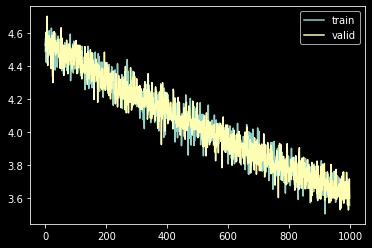

In [19]:
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
import collections
import random
import matplotlib.pyplot as plt
import matplotlib

WORD_LEN = 8
BATCH_SIZE = 32
VOCAB_SIZE = 65  # Where did 32 come from for C?
# N_EMBD = 32
NUM_STEPS = 1000
VALIDATION_FRACTION = 0.8

with open('input.txt', 'r') as f:
    contents = f.read()

def pick_random_batches(contents, vocab_dict, validation = False):
    input = torch.zeros((BATCH_SIZE, WORD_LEN), dtype=torch.int64)
    target = torch.zeros((BATCH_SIZE, WORD_LEN), dtype=torch.int64)
    for i in range(BATCH_SIZE):
        start = random.randint(0, int((len(contents) - WORD_LEN - 1) * VALIDATION_FRACTION))
        if validation:
            start = random.randint(int(len(contents) * VALIDATION_FRACTION), (len(contents) - WORD_LEN - 1))
        input[i] = torch.tensor([vocab_dict[c]
                              for c in contents[start:start+WORD_LEN]])
        target[i] = torch.tensor([vocab_dict[c]
                              for c in contents[start + 1:start + 1 + WORD_LEN]])
    return (input, target)
    # input = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7]).repeat(BATCH_SIZE, 1)
    # target = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8]).repeat(BATCH_SIZE, 1)
    # return (input, target)

class ValidDataLoaderIterator:
    def __init__(self):
        self.idx = int(len(contents) * VALIDATION_FRACTION)

    def __next__(self):
        if self.idx + 1 + WORD_LEN > len(contents):
            raise StopIteration

        input = torch.zeros((BATCH_SIZE, WORD_LEN), dtype=torch.int64)
        target = torch.zeros((BATCH_SIZE, WORD_LEN), dtype=torch.int64)
        for i in range(BATCH_SIZE):
            input[i] = torch.tensor([vocab_dict[c]
                                for c in contents[self.idx:self.idx+WORD_LEN]])
            target[i] = torch.tensor([vocab_dict[c]
                                for c in contents[self.idx + 1:self.idx + 1 + WORD_LEN]])
            self.idx += WORD_LEN
        return (input, target)

class ValidDataLoader:
    def __init__(self):
        pass
    
    def __iter__(self):
        return ValidDataLoaderIterator()

        


def get_vocab(contents):
    vocab_dict = {}

    letters = collections.defaultdict(int)
    for c in contents:
        letters[c] += 1
    keys = sorted(letters.keys())
    count = 0
    for k in keys:
        # print('fill', k, count)
        vocab_dict[k] = count
        count += 1
    # print(vocab_dict)
    # print(len(keys))
    return vocab_dict

class BigramModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(VOCAB_SIZE, VOCAB_SIZE)
        # self.sm = nn.Softmax(dim=2)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input, target):
        # input is (B, T)
        # output is (B, T, C)
        logits = self.embedding(input)
        loss = self.loss_fn(torch.permute(logits, (0, 2, 1)), target)
        # print('out sum', out[0, 0].sum())
        return logits, loss

    # TODO make this more Karpathy-like.
    def generate(self, vocab_dict, length):
        # input is simply (T)
        # output is (T, C)
        current = torch.zeros((1, WORD_LEN), dtype=torch.int64)
        ret = []
        vocab_dict_reverse = {v: k for k, v in vocab_dict.items()}
        for i in range(length):
            logits = self.embedding(current)
            # idx = logits[0][WORD_LEN - 1].argmax().item() # Pick stochastically instead
            idx = torch.multinomial(F.softmax(logits[0][WORD_LEN - 1], dim=0), 1).item()

            ret.append(vocab_dict_reverse[idx])
            current = torch.cat([current[:, 1:], torch.tensor([[idx]])], dim=1)

        logits = self.embedding(current)
        print('logits', logits[0][WORD_LEN - 1])
        print('softmax', F.softmax(logits[0][WORD_LEN - 1], dim=0))
        return ''.join(ret)

# def loss_fn(output, target):
#     target_one_hot = F.one_hot(target, num_classes=VOCAB_SIZE)
#     # print(output.shape, target.shape, target_one_hot.shape)
#     # print((output - target_one_hot)[0,0])
#     # print(output.sum(dim=2))
#     # print('sums', ((output - target_one_hot) ** 2).sum(dim=2))
#     return ((output - target_one_hot) ** 2).sum()
        



vocab_dict = get_vocab(contents)

model = BigramModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss = None
train_losses = []
valid_losses = []
for i in range(NUM_STEPS):
    train_input, train_target = pick_random_batches(contents, vocab_dict, validation = False)
    # print(input.dtype)
    optimizer.zero_grad()
    _output, loss = model(train_input, train_target)
    # print(output.shape)
    # loss = loss_fn(output, target)


    # print(model.parameters())
    loss.backward()
    # for param in model.parameters():
    #     print('grad shape', param.grad.shape)
    #     print('add grad', param.grad)
    optimizer.step()
    
    valid_input, valid_target = pick_random_batches(contents, vocab_dict, validation = True)
    with torch.no_grad():
        _output, valid_loss = model(valid_input, valid_target)
    train_losses.append(loss.item())
    valid_losses.append(valid_loss.item())
print('train loss', loss)

# matplotlib.style.use('default')
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
# plt.show()

print(model.generate(vocab_dict, 100))

